# PHYS20762 - Project 2 - Numerical Integration

Robert Hartley<br>
University of Manchester  
April 2022

### Initalization

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks
from datetime import datetime

plt.rc('text', usetex=True) 
plt.style.use('default')

## Project Outline:
The purpose of this project is to study a spring-mass system governed by the differential equation:$$m\ddot{x}(t)+b\dot{x}(t)+kx(t) = F(t),$$
where $m$ is the mass of the particle, $b$ is the damping constant, $k$ is the spring constant, $F(t)$ is an external force and $\ddot(x)$, $\dot(x)$, $x$ are the acceleration, velocity and position of the particle respectively. This system can only be solved analytically when $F(t) = 0$. In this project, the analytical solution will be compared to four numerical methods to determine which one is the best. The numerical methods used in this project are Euler's method, Improved-Euler's method, Verlet's method and the Euler-Cromer method.

### Project Aims:
- Numerically analyse spring-mass system
- First study the case when $F(t) \neq 0$
- Study a sudden push force (Modelled as a Gaussian distribution)
- Study a periodic driving force.
- Study the effect of driving frequency on the amplitude of the system.

Define constants:

$k$ = 2.02                                                                                                       
$m$ = 3.05

In [95]:
#Setting physical parameters
k = 2.02 # The spring constant in kg/s^2
mass = 3.05 # The mass of the particle in kg
b = 0.18 # The damping constant in kg/s

T=200 # total time of system in s
x0 = 1 #Inital displacement of particle in m
v0 = -1 #Inital velocity of particle in ms/s


#Colours of graph lines for continuity
COLOUR = ['orange', 'fuchsia', 'red', 'blue', '#129022']


### Analytical Solution
Analytical solution for unforced spring-mass system :
$$x(t) = e^{-\frac{\gamma t}{2}}(A e^{i \omega t} + B e^{-i \omega t})$$

where, $\gamma = \frac{b}{m}$, $\omega ^2 = \omega ^2_0 - \frac{\gamma^2}{4}$, $\omega_0 = \sqrt{\frac{k}{m}}$.

We can find A and B using our intial conditions $x_0 = x(0)$, $v_0 = v(0)$.       
$A = \frac{v_0}{i \gamma \omega} + \frac{x_0}{2}$          
$B = x_0 - A$

We also know that the total energy of the system will be equal to:
$$E = \frac{1}{2}mv^2+\frac{1}{2}kx^2$$


In [96]:
def Analytic(time, b=b):
    '''Method to numerically solve a differential equation using the analytical method
    Parameters:
    time - array of times - nsteps long - array of floats
    b - damping constant - float
    ----------
    Returns:
    x - array of length of nsteps of positions - array of floats
    v - array of length of nsteps of velocity - array of floats
    E - array of length of nsteps of energy - array of floats'''
    #Consants
    gamma = b/mass # Damping ratio in kg^-1
    w = np.sqrt(k/mass - (b ** 2 / (4*mass**2))) #Angular frequency of the system in rad/s
    #Define constants A and B as above
    A = v0 / (2 * 1j * w) + x0*(1/2 + gamma / (4 * 1j * w))
    B = x0 - A
    #Calculate x, an array, for each step in time
    x = np.exp(-gamma * time / 2) * (A * np.exp(1j * w * time) + B * np.exp(-1j * w * time))
    
    v = (A * (1j * w - gamma/2) * np.exp((1j * w - gamma/2) * time)) - (B * (1j * w + gamma/2) * np.exp(-time * (1j * w + gamma/2)))
    #Energy of the system
    E =  1/2 * k * x ** 2 + 1/2 * mass * v ** 2

    return x.real, v.real, E.real





### Numerical Integration:
#### First method - Euler's Method  
Euler's Method utilizes a Taylor expansion on our equation of motion at time $t+h$, where h is a _small_ time step. 
$$x(t+h) = x(t) + h\dot{x}(t) + {O}(h^2),$$
where $O(h^2)$ is a truncated error of order $h^2$. From this Euler's method can be found by taking the derivative of the above equation, giving these equations of motion:   
$$x_{t+h} = x_{t} + h\dot{x}_{t},$$
$$\dot{x}_{t+h} = \dot{x}_{t} + h\ddot{x}_{t} ,$$
where $\ddot{x}_{t}$ is calculated from the analytical equations of motion above
$$\ddot{x}_{t} = -\frac{k}{m}x_{t} -\frac{b}{m}\dot{x}_{t}.$$
These equations allow us to calculate the position and velocity at any step $h$ in time.

In [4]:
def EulerMethod(nsteps, hstep, b=b):
    '''Method to numerically solve a differential equation using Euler's Method
    Parameters:
    nsteps - amount of steps the system will take - integer
    hstep - gap in time inbetween values calcaulted - float
    b - damping constant - float
    ----------
    Returns:
    x - array of length of nsteps of positions - array of floats
    v - array of length of nsteps of velocity - array of floats
    E - array of length of nsteps of energy - array of floats'''
    
    # Create empty arrays for x, v and E
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)

    # Assign initial conditions
    x[0] = x0 
    v[0] = v0
    
    for i in range(nsteps-1):

        # Calculate the acceleration at step i (in m/s)
        
        a = -(k/mass)*x[i] - (b/mass)*v[i]

        x[i+1] = x[i] + v[i]*hstep
        v[i+1] = v[i] + a*hstep
    E = 1/2 * k * x ** 2 + 1/2*mass*v ** 2
        
        
    return (x, v, E) 


#### Second Method  - Improved Euler Method:
The Improved Euler method uses the same taylor expansion as the Euler method, however takes it one order higher, so $x(t+h)$ is now :
$$x(t+h) = x(t) + h\dot{x}(t) + \frac{1}{2}h^2\ddot{x}(t)+{O}(h^3),$$
where $O(h^3)$ is now the truncated order of $h^3$.
The equations of motion now become:
$$x_{t+h} = x_t+h\dot{x}_t + \frac{1}{2}h^2\ddot{x}_t$$
$$\dot{x}_{t+h} = \dot{x}_{t} + h\ddot{x}_{t} ,$$
where $\ddot{x}_{t}$ is the same as Eulers method


In [98]:
def ImprovedEuler(nsteps, hstep, b=b):
    '''Method to numerically solve a differential equation using the Improved Euler's Method
    Parameters:
    nsteps - amount of steps the system will take - integer
    hstep - gap in time inbetween values calcaulted - float
    b - damping constant - float
    ----------
    Returns:
    x - array of length of nsteps of positions - array of floats
    v - array of length of nsteps of velocity - array of floats
    E - array of length of nsteps of energy - array of floats'''
    
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    
    # Assign initial conditions
    x[0] = x0 
    v[0] = v0

    for i in range(nsteps-1):

        # Calculate the acceleration at step i (in m/s)
        a = -(k/mass)*x[i] - (b/mass)*v[i]

        # For each configuration at step i, calculate x (in m) and v (in m/s) for the later step i+1
        x[i+1] = x[i] + v[i] * hstep + a * hstep ** 2 / 2
        v[i+1] = v[i] + a * hstep
    E = 1/2 * k * x ** 2 + 1/2 * mass * v ** 2
    
    return x, v, E


#### Third Method - Verlet's Method
Verlet's Method comes from a centered derivative :
$$\dot{x}(t) = \displaystyle{\lim_{h \to 0}}\frac{x(t+h) - x(t-h)}{2h}.$$
Calculate two taylor expansions around $x(t+h)$ and $x(t-h)$ respectively.
$$x(t+h) = x(t) + h\dot{x}(t) + \frac{1}{2}h^2\ddot{x}(t)+{O}(h^3),$$
$$x(t-h) = x(t) - h\dot{x}(t) + \frac{1}{2}h^2\ddot{x}(t)+{O}(h^3),$$
This can be rearranged to give:
$$x_{t+h} = 2x_t - x_{t-h} + h^2\ddot{x}_t + O(h^4)$$
$$\dot{x}_t = \frac{x_{t+h} - x_{t-h}}{2h},$$
$$\ddot{x}_{t} = -\frac{k}{m}x_t - \frac{b}{m}\dot{x}_t$$
This can be rearranged to give 
$$x_{t+h} = A x_{t}+B x_{t-h},$$
Where 
$$A = 2\frac{2m - kh^2}{D}$$
$$B = 2\frac{bh - 2m}{D}$$
And $D = 2m+bh$



In [99]:
def VerletMethod(nsteps, hstep, b=b, F = []):
    '''Method to numerically solve a differential equation using Verlet's Method
    Parameters:
    nsteps - amount of steps the system will take - integer
    hstep - gap in time inbetween values calcaulted - float
    b - damping constant - float
    F - array of the force at each time - array of floats
    ----------
    Returns:
    x - array of length of nsteps of positions - array of floats
    v - array of length of nsteps of velocity - array of floats
    E - array of length of nsteps of energy - array of floats'''
    
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    a = np.zeros(nsteps)

    time = np.arange(0,T, hstep)
    
    if len(F) != nsteps: #To keep dimensionality  later when adding force to x array
        F = np.zeros(nsteps)
    
    #Constants
    D = 2*mass + b * hstep
    A = 2 * (2 * mass - (k * (hstep**2))) / D
    B = (b * hstep - 2 * mass) / D
    
    #Need to find x1
    (x1, v1, _) = ImprovedEuler(2, hstep)
    x[0:2] = x1
    v[0:2] = v1
    
    for i in range(1,nsteps-1):
        ###Generalized method to include force for later on in project.
        
        #Calculate x[i+1] using ith and {i+1}th x values
        x[i+1] = A*x[i] + B*x[i-1]
        #Calculate centred derivative
        v[i] = (x[i+1] - x[i-1]) / (2 * hstep)
        
        #Calculate acceleration with added force
        a[i] = -(k/mass)*x[i] - (b/mass)*v[i] + F[i]/mass
        #Recalculate x value with new acceleration
        x[i+1] = (2 * x[i]) - x[i-1] + ((hstep**2) * a[i])  
        
    E = 1/2 * k * x ** 2 + 1/2 * mass * v ** 2
    
    return x, v, E

#### Fourth Method - Euler-Cromer Method
The Euler-Cromer Method is sympletic, like Verlet's Method, and thus conserves energy. This is done by modifying the Euler Method, the equations of motion are now :
$$x_{t+h} = x_t+h\dot{x}_\mathbf{{t+h}}$$
$$\dot{x}_{t+h} = \dot{x}_t - \frac{hk}{m}x_t$$

In [100]:
def EulerCromer(nsteps, hstep, b=b):
    '''Method to numerically solve a differential equation using the Euler-Cromer Method
    Parameters:
    nsteps - amount of steps the system will take - integer
    hstep - gap in time inbetween values calcaulted - float
    b - damping constant - float
    ----------
    Returns:
    x - array of length of nsteps of positions - array of floats
    v - array of length of nsteps of velocity - array of floats
    E - array of length of nsteps of energy - array of floats'''
    
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)

    
    x[0] = x0 
    v[0] = v0
    
    for i in range(nsteps - 1):
        a = -(k/mass)*x[i] - (b/mass)*v[i]
        #Euler Cromer includes v[i+1] to conserve energy.
        v[i+1] = v[i] + a*hstep
        x[i+1] = x[i] + v[i+1]*hstep
    
    E = 1/2*k*x ** 2 + 1/2*mass*v ** 2
        
    return x, v, E

#### Investigating accuracies of methods
For a given time step of 0.02 seconds, we will now explore the accuracies of the methods defined above. This will be done first graphically by showing each method against the analytical solution. We will then look at each method on a zoomed-in plot around one peak.

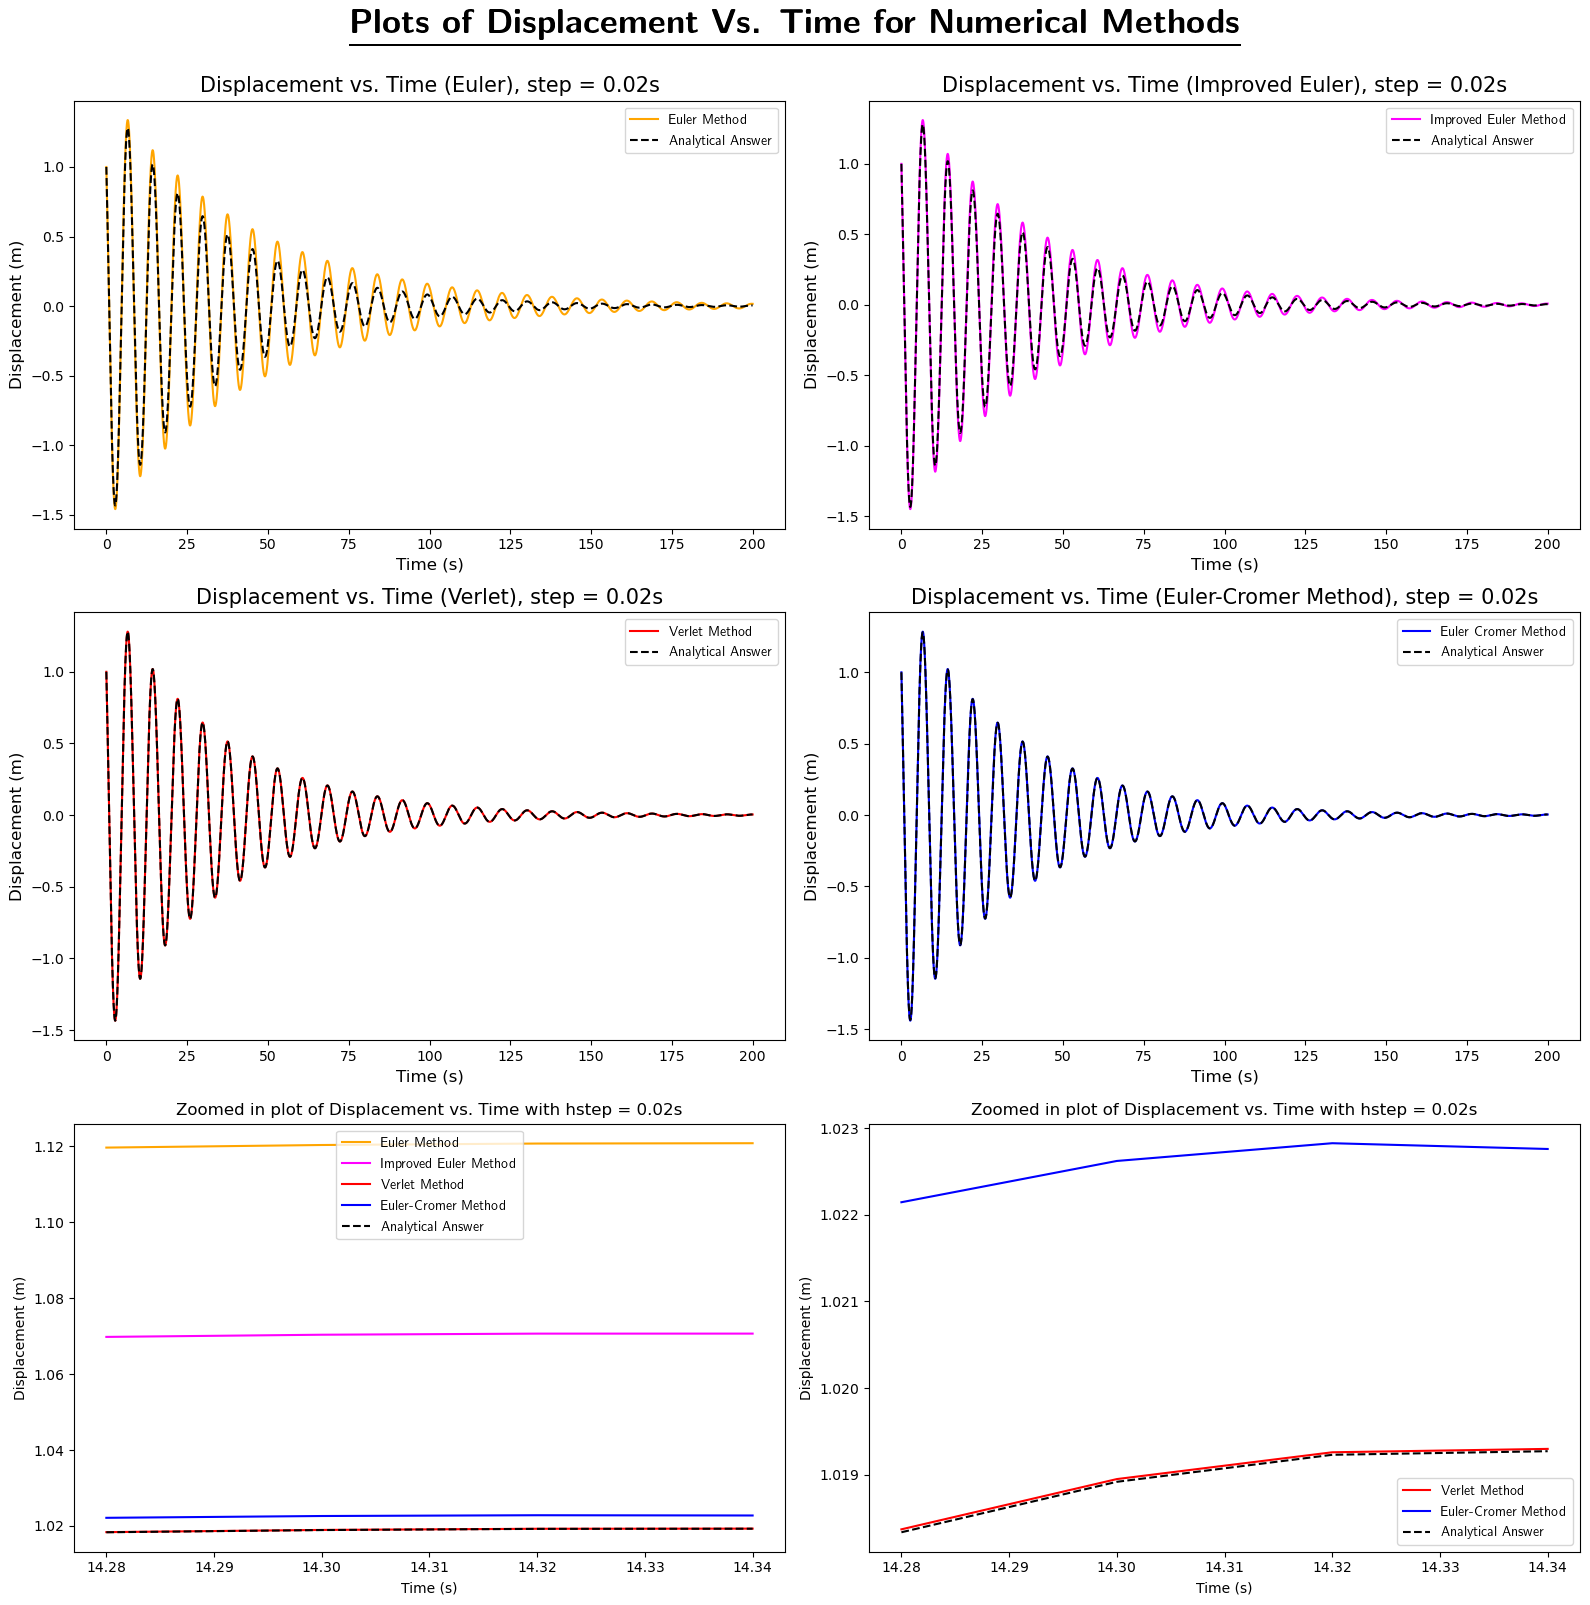

In [101]:
hstep = 0.02 # Assert a value for hstep
nsteps = int(T/hstep) # Calculate how long the arrays will be
time = np.arange(0,T, hstep) 

#Calculate the solutions using each method
(euler_x, euler_v, euler_E) = EulerMethod(nsteps, hstep)
(improv_e_x, improv_e_v, improv_e_E) = ImprovedEuler(nsteps, hstep)
(ver_x, ver_v, ver_E) = VerletMethod(nsteps, hstep)
(cromer_x, cromer_v, cromer_E) = EulerCromer(nsteps, hstep)
ana_x, ana_v, ana_E = Analytic(time)


#Plotting analytical against each numerical method
plt.rcParams["figure.figsize"] = (16,16)
#Create 6 subplots, one for each numerical method, and two for zooming in one peak.
fig,((Euler_ax, I_Euler_ax), (Verlet_ax, E_Cromer_ax),(zoom4_ax, zoom2_ax)) = plt.subplots(3,2)

plt.rc('text', usetex=True) #Allow matplotlib to use tex (default package doesnt have \underline)
plt.suptitle(r'\textbf{\underline{Plots of Displacement Vs. Time for Numerical Methods}}', fontsize = 25, y=1)

#Plot the Euler method solution
Euler_ax.plot(time, euler_x, label='Euler Method', c=COLOUR[0])
Euler_ax.plot(time, ana_x, 'k--', label='Analytical Answer')
Euler_ax.set_title('Displacement vs. Time (Euler), step = ' + str(hstep) + 's', fontsize=15)
Euler_ax.set_xlabel('Time (s)', fontsize=12)
Euler_ax.set_ylabel('Displacement (m)', fontsize=12)
Euler_ax.legend()

#Plot the Improved Euler method solution
I_Euler_ax.plot(time, improv_e_x, label='Improved Euler Method', c=COLOUR[1])
I_Euler_ax.plot(time, ana_x, 'k--', label='Analytical Answer')
I_Euler_ax.set_title('Displacement vs. Time (Improved Euler), step = ' + str(hstep) + 's', fontsize=15)
I_Euler_ax.set_xlabel('Time (s)', fontsize=12)
I_Euler_ax.set_ylabel('Displacement (m)', fontsize=12)
I_Euler_ax.legend()

#Plot the Verlet Method solution
Verlet_ax.plot(time, ver_x, label='Verlet Method', c=COLOUR[2])
Verlet_ax.plot(time, ana_x, 'k--', label='Analytical Answer')
Verlet_ax.set_title('Displacement vs. Time (Verlet), step = ' + str(hstep) + 's', fontsize=15)
Verlet_ax.set_xlabel('Time (s)', fontsize=12)
Verlet_ax.set_ylabel('Displacement (m)', fontsize=12)
Verlet_ax.legend()

#Plot the Euler-Cromer Method solution
E_Cromer_ax.plot(time, cromer_x, label='Euler Cromer Method', c=COLOUR[3])
E_Cromer_ax.plot(time, ana_x, 'k--', label='Analytical Answer')
E_Cromer_ax.set_title('Displacement vs. Time (Euler-Cromer Method), step = ' + str(hstep) + 's', fontsize=15)
E_Cromer_ax.set_xlabel('Time (s)', fontsize=12)
E_Cromer_ax.set_ylabel('Displacement (m)', fontsize=12)
E_Cromer_ax.legend()

#Perform zoomed in plot on Euler-Cromer and Verlet methods.
period = (2*np.pi)/(np.sqrt(k/mass - (b ** 2 / (4*mass**2))))
#Zoom in on one peak
zoom_time = 1.848*period
end_zoom_time = 1.86*period

start = round(zoom_time/T*nsteps)
end = round(end_zoom_time/T*nsteps)

#Zoomed in plot of all four methods
zoom4_ax.plot(time[start:end], euler_x[start:end], label='Euler Method', c=COLOUR[0])
zoom4_ax.plot(time[start:end], improv_e_x[start:end], label='Improved Euler Method', c=COLOUR[1])
zoom4_ax.plot(time[start:end], ver_x[start:end], label='Verlet Method', c=COLOUR[2])
zoom4_ax.plot(time[start:end], cromer_x[start:end], label='Euler-Cromer Method', c=COLOUR[3])
zoom4_ax.plot(time[start:end], ana_x[start:end], 'k--', label='Analytical Answer')
zoom4_ax.set_title('Zoomed in plot of Displacement vs. Time with hstep = '+str(hstep) + 's')
zoom4_ax.set_ylabel('Displacement (m)')
zoom4_ax.set_xlabel('Time (s)')
zoom4_ax.legend()

#Zoomed in plot of Verlet and Euler-Cromer methods - most accurate solutions
zoom2_ax.plot(time[start:end], ver_x[start:end], label='Verlet Method', c=COLOUR[2])
zoom2_ax.plot(time[start:end], cromer_x[start:end], label='Euler-Cromer Method', c=COLOUR[3])
zoom2_ax.plot(time[start:end], ana_x[start:end], 'k--', label='Analytical Answer')
zoom2_ax.set_title('Zoomed in plot of Displacement vs. Time with hstep = '+str(hstep) + 's')
zoom2_ax.set_ylabel('Displacement (m)')
zoom2_ax.set_xlabel('Time (s)')
zoom2_ax.legend()

plt.tight_layout() #Tight layout to stop any overlapping between subplots
plt.show()
plt.rc('text', usetex=False) #Allow matplotlib to use tex (default package doesnt have \underline)



It is clear from the zoomed-in graph around the second peak that both Euler's and the Improved Euler's methods are much less accurate than the Euler-Cromer and Verlet's methods. The Verlet method is almost inseparable from the analytical in both zoomed-in plots, so to better understand the errors associated with each numerical method, we shall look into the percentage uncertainty in the energy.

#### Errors and uncertainty
A good measure of how accurate a numerical method is is looking at the percentage uncertainty. In this project we will compare values of percentage uncertainty calculated using this formula;
$$\sigma_{\%}=\frac{1}{N}\sum_{n=0}^{N} {\frac{|E_n-E^{ana}_n|}{E_n}},$$
where $E_n$ is the nth value of the energy, calculated using the relevant numerical method. $E^{ana}_n$ is then the nth value of energy calculated by the analytical solution. 


In [103]:
def average_uncertainty(hstep):
    nsteps = int(T/hstep)
    time = np.linspace(0,T, nsteps)
    #Recalculating positions for each 
    (_, _, euler_E) = EulerMethod(nsteps, hstep)
    (_, _, improv_e_E) = ImprovedEuler(nsteps, hstep)
    (_, _, ver_E) = VerletMethod(nsteps, hstep)
    (_, _, cromer_E) = EulerCromer(nsteps, hstep)
    _, _, ana_E = Analytic(time)

    #Calcualte Percentage Uncertainty
    err_Euler = np.mean(np.abs(euler_E - ana_E) / euler_E)
    err_I_Euler = np.mean(np.abs(improv_e_E - ana_E) / improv_e_E)
    err_Ver = np.mean(np.abs(ver_E - ana_E) / ver_E)
    err_Cromer = np.mean(np.abs(cromer_E - ana_E) / cromer_E)
    
    return (err_Euler, err_I_Euler, err_Ver, err_Cromer)
    

We now investigate how the respective percentage uncertainties change as the time step increases. 

[]

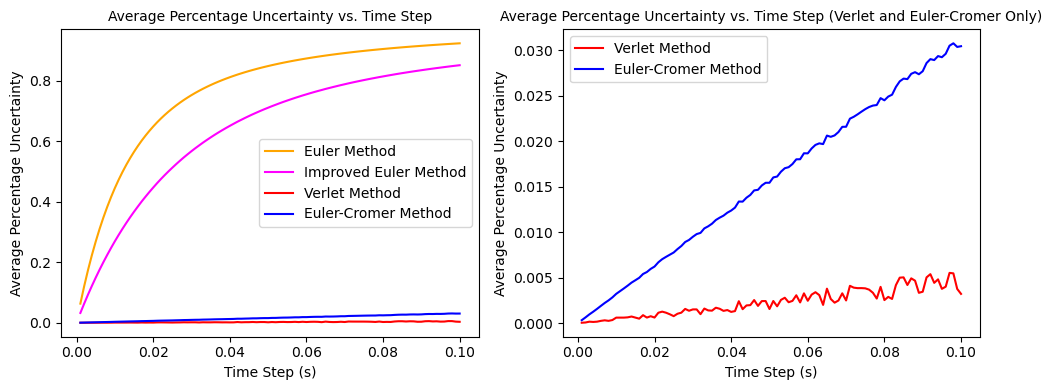

In [104]:
#Create array of hsteps inbetween 0.001s and 0.1s
hsteps = np.linspace(0.001,0.1,100)

#Create empty arrays for each methods errors
err_Euler = np.zeros(len(hsteps))
err_I_Euler = np.zeros(len(hsteps))
err_Ver = np.zeros(len(hsteps))
err_Cromer = np.zeros(len(hsteps))

for index,hstep in enumerate(hsteps):
    #Calculate average percentage uncertainty for each hstep
    (err_Euler[index], err_I_Euler[index], err_Ver[index], err_Cromer[index]) = average_uncertainty(hstep)

#Define figure size and create two subplots for the errors on all four methods, and then just Euler Cromer and Verlet.
plt.rcParams["figure.figsize"] = (10,4)
fig,(err_all, err_two) = plt.subplots(1,2)

err_all.plot(hsteps, err_Euler, c=COLOUR[0], label='Euler Method')
err_all.plot(hsteps, err_I_Euler, c=COLOUR[1], label='Improved Euler Method')
err_all.plot(hsteps, err_Ver, c=COLOUR[2], label='Verlet Method')
err_all.plot(hsteps, err_Cromer, c=COLOUR[3], label='Euler-Cromer Method')
err_all.set_title('Average Percentage Uncertainty vs. Time Step', fontsize=10)
err_all.set_xlabel('Time Step (s)')
err_all.set_ylabel('Average Percentage Uncertainty')

#Plot of just Euler-Cromer and Verlet to better see the difference between them
err_two.plot(hsteps, err_Ver, c=COLOUR[2], label='Verlet Method')
err_two.plot(hsteps, err_Cromer, c=COLOUR[3], label='Euler-Cromer Method')
err_two.set_title('Average Percentage Uncertainty vs. Time Step (Verlet and Euler-Cromer Only)', fontsize=10)
err_two.set_xlabel('Time Step (s)')
err_two.set_ylabel('Average Percentage Uncertainty')

err_all.legend()
err_two.legend()
plt.tight_layout()
plt.plot()

Once again the Euler and Improved Euler methods have large uncertainties, this is due to them being non-symplectic. This can be seen in the graph below, when b = 0, Euler and Improved Euler both calculate $E_{i+1} > E_{i}$.

It can be seen that the Verlet Method is once again the best solution, with the least amount of average percentage uncertainty.

### Symplectic and Non-Symplectic methods
Symplectic methods are those that conserve energy, this can be demonstrated by plotting solutions for when the damping term is zero. This can also be seen from the theory.
#### Euler's method for zero damping
With $b=0$, Euler's equations now become (changing $t, t+h$ to $i, i+1$);
$$x_{i+1} = x_i + h\dot{x}_i $$
$$\dot{x}_{i+1} = \dot{x}_i + h\ddot{x}_i$$
where $$\ddot{x}_i = -\frac{k}{m}x_i$$
Now calculate $E_{i+1}$;
$$E_{i+1} = \frac{1}{2}k(x_i+h\dot{x}_i)^2 + \frac{1}{2}m(\dot{x}_i+h\ddot{x}_i)^2$$
$$E_{i+1} = \frac{1}{2}k(x_i)^2 + \frac{1}{2}m(\dot{x}_i)^2 + \frac{1}{2}\frac{h^2k^2x_i^2}{m}+ \frac{1}{2}h^2k\dot{x}_i$$
$$E_{i+1} = E_i (1+\frac{k}{m}h^2)$$
#### The Improved Euler Method
Similarly the energy can be calculated for the Improved Euler Method.
$$x_{i+1} = x_i + h\dot{x}_i + \frac{1}{2}h^2\ddot{x}_i$$
$$\dot{x}_{i+1} = \dot{x}_i + h\ddot{x}_i$$
where $$\ddot{x}_i = -\frac{k}{m}x_i$$
Using the same method we get;
$$E_{i+1} = E_{i} + h^2 \dot{x}_i^2 - \frac{h^3k}{m}\dot{x}_i x_i + \frac{h^4k^3}{8m^2}x_i^2$$

[]

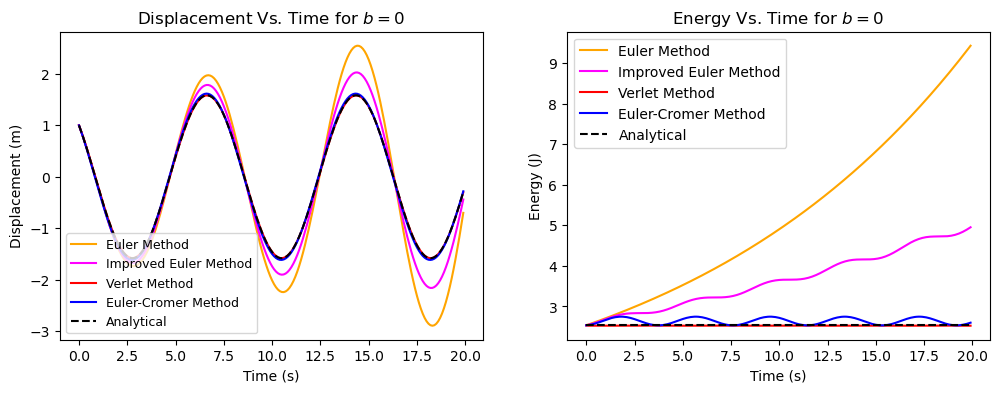

In [11]:
hstep = 0.1
nsteps = int(T/hstep)
time = np.linspace(0, T, nsteps)

#Recalculating positions for each 
(euler_x, _, euler_E) = EulerMethod(nsteps, hstep, b=0)
(improv_e_x, _, improv_e_E) = ImprovedEuler(nsteps, hstep, b=0)    
(ver_x, _, ver_E) = VerletMethod(nsteps, hstep, b=0)
(cromer_x, _, cromer_E) = EulerCromer(nsteps, hstep, b=0)
ana_x, _, ana_E = Analytic(time, b=0)

plt.rcParams["figure.figsize"] = (12,4)
#Create two subplots, one for displacement, one for energy.
fig,(x_plot, E_plot) = plt.subplots(1,2)
end = round(20/T*nsteps) #Only show the first 20 seconds

#Displacement plot
x_plot.plot(time[:end], euler_x[:end], label='Euler Method', c=COLOUR[0])
x_plot.plot(time[:end], improv_e_x[:end], label='Improved Euler Method', c=COLOUR[1])
x_plot.plot(time[:end], ver_x[:end], label='Verlet Method', c=COLOUR[2])
x_plot.plot(time[:end], cromer_x[:end], label='Euler-Cromer Method', c=COLOUR[3])
x_plot.plot(time[:end], ana_x[:end], 'k--', label='Analytical')
x_plot.set_title(r'Displacement Vs. Time for $b=0$')
x_plot.set_xlabel('Time (s)')
x_plot.set_ylabel('Displacement (m)')

#Energy plot
E_plot.plot(time[:end], euler_E[:end], label='Euler Method', c=COLOUR[0])
E_plot.plot(time[:end], improv_e_E[:end], label='Improved Euler Method', c=COLOUR[1])
E_plot.plot(time[:end], ver_E[:end], label='Verlet Method', c=COLOUR[2])
E_plot.plot(time[:end], cromer_E[:end], label='Euler-Cromer Method', c=COLOUR[3])
E_plot.plot(time[:end], ana_E[:end], 'k--', label='Analytical')
E_plot.set_title(r'Energy Vs. Time for $b=0$')
E_plot.set_xlabel('Time (s)')
E_plot.set_ylabel('Energy (J)')

x_plot.legend(loc='lower left', fontsize=9)
E_plot.legend(loc='upper left')
plt.plot()

It is clear from both graphs that the Euler and Improved Euler methods are non-symplectic - as expected from the theory.

### Critical Damping
Plotting solutions for different values of damping.
Critical value of damping is = $b_{cr} = 2\sqrt{{k}\cdot{m}}$.
I will plot solutions for $b = 1/2 b_{cr}$, $b = b_{cr}$ and $b = 2b_{cr}$

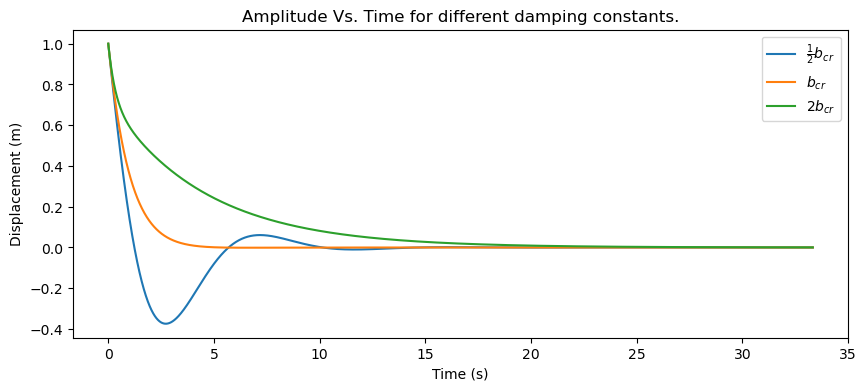

Where, for this system, the critical damping constant is = 4.96 kg/s


In [12]:
hstep = 0.1
#Defining the values of damping constant relative to critical damping
crit_b = 2 * np.sqrt(k*mass)
b_values = [1/2*crit_b, crit_b, 2*crit_b]
labels = [r'$\frac{1}{2}$', '', '2']

hstep = hsteps[0]
nsteps = int(T/hstep/6)
time = np.linspace(0,T/6, nsteps)
#Resizing plots
plt.rcParams["figure.figsize"] = (10,4)
#Plotting for each value of damping
for index, b_value in enumerate(b_values):
    (ver_x, ver_v, ver_E) = VerletMethod(nsteps, hstep, b = b_value)
    plt.plot(time, ver_x, label=labels[index]+r'$b_{cr}$')
    
plt.title('Amplitude Vs. Time for different damping constants.')  
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.legend()    
plt.show()    

print('Where, for this system, the critical damping constant is = {:.2f} kg/s'.format(crit_b))


### Explanation of damping curves
When the damping is equal to $\frac{1}{2}b_{cr}$, the system is undamped, this is seen in the small oscillation around the equilibrium. When damping is equal to the critical damping, the system returns to equilibrium, without oscillation, in the fastest possible time. When damping is overdamped, or larger than $b_{cr}$, the system returns to equilibrium slower than critical, and will also slightly oscillate on the way down.

### Simulation with a sudden external force.
There is no analytical solution for when a spring-mass system is affected by an external force, so we have to rely on numerical integration. The sudden external force could be represented in various ways, however here it will be represented as a Gaussian distribution, as it has more physical significance, as opposed to a Dirac delta function.

In [13]:
def GaussianForce(time, F_0, force_time, width):
    '''Function that calculates the force as a function of time in a Gaussian distribution
    Parameters:
    time - array of times with time step hstep - array of floats
    F_0 - Magnitude of force at force_time - float
    force_time - time where the maximum force occurs - float
    width - width of distribution - float
    ----------
    Returns:
    Gaussian distribution'''
    
    return F_0 / (width * np.sqrt(2*np.pi)) * np.exp(-1/2*((time - force_time)/width)**2)

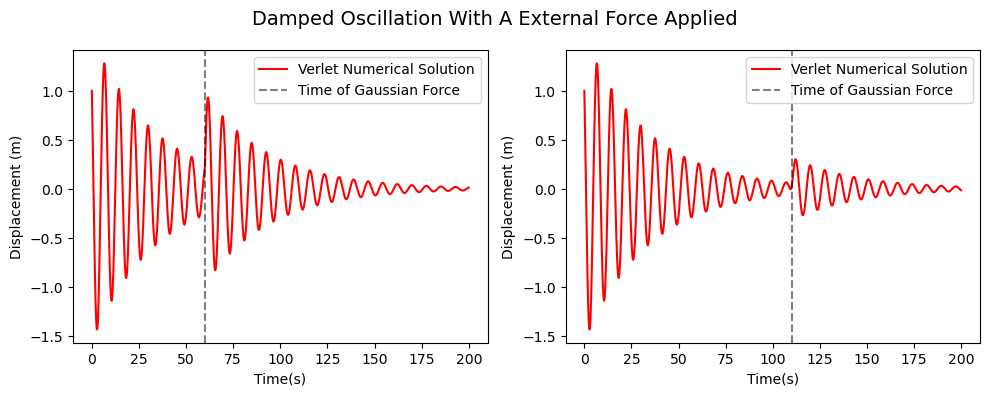

In [105]:
hstep = 0.1
nsteps = int(T/hstep)
time = np.arange(0,T, hstep)
#Setting constants for first force
F_0 = 2
force_time = 60 
width = 0.1

#Calculating the force as a Gaussian distribution
F_func = GaussianForce(time, F_0, force_time, width)

#Calculating the numerical integration solution using Verlet method.
ver_x, ver_v, ver_E = VerletMethod(nsteps, hstep, F = F_func )
ana_x, _, _ = Analytic(time)

#Plotting the solution of the externally pushed system
fig,(ax_1, ax_2) = plt.subplots(1,2)

ax_1.plot(time, ver_x, label='Verlet Numerical Solution', c=COLOUR[2])
ax_1.axvline(x=force_time, label='Time of Gaussian Force', c='black', linestyle='--', alpha=0.5)
ax_1.set_xlabel('Time(s)', fontsize=10)
ax_1.set_ylabel('Displacement (m)', fontsize=10)
ax_1.legend()

#Setting constants for second force
F_0 = 1
force_time = 110 
width = 0.6

#Calculating the solution of the externally pushed system

F_func = GaussianForce(time, F_0, force_time, width)

ver_x, ver_v, ver_E = VerletMethod(nsteps, hstep, F = F_func )
ana_x, _, _ = Analytic(time)
#Plotting the solution of the periodic force driven system

ax_2.plot(time, ver_x, label='Verlet Numerical Solution', c=COLOUR[2])
ax_2.axvline(x=force_time, label='Time of Gaussian Force', c='black', linestyle='--', alpha=0.5)
ax_2.set_xlabel('Time(s)', fontsize=10)
ax_2.set_ylabel('Displacement (m)', fontsize=10)
ax_2.legend()

plt.suptitle('Damped Oscillation With A External Force Applied', fontsize=14)

plt.tight_layout()
plt.show()

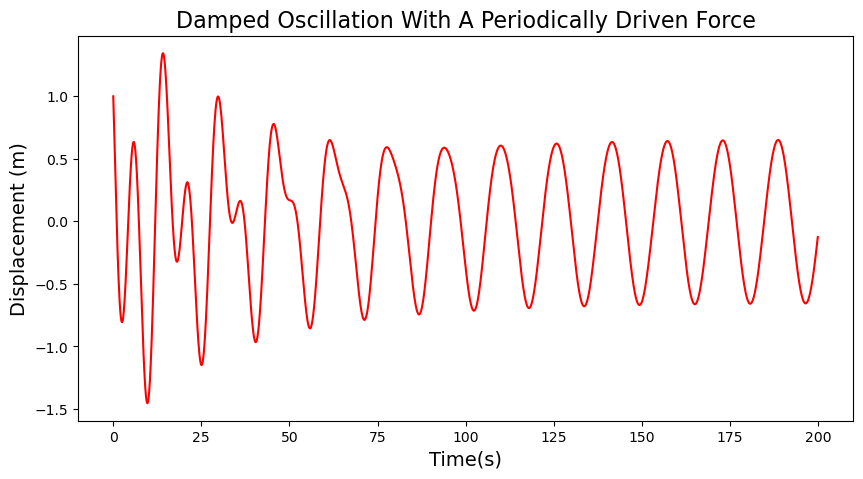

In [106]:
F_0 = 0.1
omega = 0.4
#Calculating the solution of the periodic force driven system
F_func = np.cos(omega * time)
ver_x, ver_v, ver_E = VerletMethod(nsteps, hstep, F = F_func )

#Plotting the solution of the periodic force driven system
plt.figure(figsize = (10,5))

plt.plot(time, ver_x, c=COLOUR[2])


plt.title('Damped Oscillation With A Periodically Driven Force', fontsize=16)
plt.xlabel('Time(s)', fontsize=14)
plt.ylabel('Displacement (m)', fontsize=14)
plt.show()

### Investigating the effect driving force frequency, $\omega$, has on the amplitude of the resulting wave



As seen in the graph above, when the system first comes into contact with a periodic driving force, it motion is determined by its initial velocity and position and is very chaotic. This is called the transient state of the system. As the transient part of the solution becomes smaller and smaller, it enters its steady state, where the amplitude of the peaks is constant. In this section, we will investigate how the amplitude of the steady-state changes as the frequency is varied.

In [16]:
def FindAmplitude(data, threshold = 0.1):
    '''Function to find the amplitude of the system once it is in its steady state.
    Parameters:
    data - displacement data - array of floats
    threshold - how strict the function is about changes in amplitude between peaks - float
    ----------
    Returns:
    amplitude - average amplitude of peaks found in steady state
    '''
    peaks, _ = find_peaks(data)
    steady_state = peaks[(np.where(abs(np.diff(data[peaks])) < threshold))]

    amplitude = np.mean(data[steady_state])
    return amplitude
    


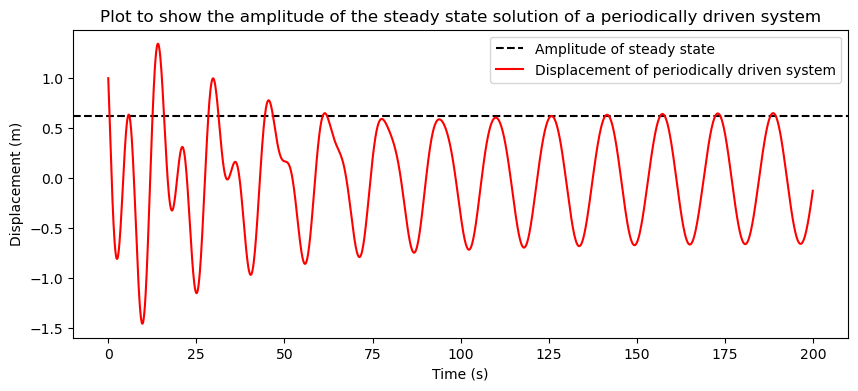

In [107]:
omega = 0.4
F_func = np.cos(omega * time) #Defining force as a cos function

X_1, _, _, = VerletMethod(nsteps, hstep, F=F_func)
Amp = FindAmplitude(X_1)
plt.axhline(y = Amp, label='Amplitude of steady state', c='black', linestyle='--')

plt.plot(time, X_1, c=COLOUR[2], label='Displacement of periodically driven system')
plt.title('Plot to show the amplitude of the steady state solution of a periodically driven system')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.legend()
plt.show()


Now investigating for multiple frequencies

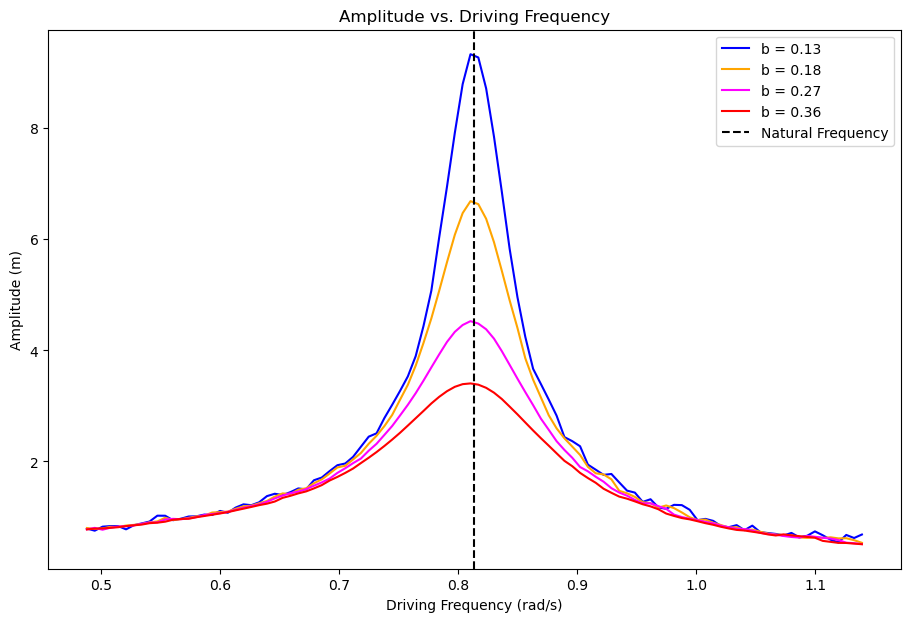

In [108]:
#Define natural frequency of system
natural_f = np.sqrt(k/mass)

#Create array of angular frequencies around natural frequency
omegas = np.linspace(0.6*natural_f, 1.4*natural_f, 100)

Amp_1 = np.zeros(len(omegas))
Amp_2 = np.zeros(len(omegas))
Amp_3 = np.zeros(len(omegas))
Amp_4 = np.zeros(len(omegas))

for index, omega in enumerate(omegas):
    #Updating periodic driving force
    F_func = np.cos(omega * time)
    
    #Calculating solutions for different damping constants
    X_1, _, _, = VerletMethod(nsteps, hstep, b=b, F=F_func)
    X_2, _, _, = VerletMethod(nsteps, hstep, b=1.5*b, F=F_func)
    X_3, _, _, = VerletMethod(nsteps, hstep, b=2*b, F=F_func)
    X_4, _, _, = VerletMethod(nsteps, hstep, b=0.7*b, F=F_func)
    
    #Finding amplitude of steady state
    Amp_1[index] = FindAmplitude(X_1)
    Amp_2[index] = FindAmplitude(X_2)
    Amp_3[index] = FindAmplitude(X_3)
    Amp_4[index] = FindAmplitude(X_4)

plt.figure(figsize = (11,7))    
plt.plot(omegas, Amp_4, c=COLOUR[3], label=r'b = {:.2f}'.format(0.7*b))
plt.plot(omegas, Amp_1, c=COLOUR[0], label=r'b = '+str(b))
plt.plot(omegas, Amp_2, c=COLOUR[1],label=r'b = '+str(1.5*b))
plt.plot(omegas, Amp_3, c=COLOUR[2], label=r'b = '+str(2*b))

plt.axvline(x=natural_f, label = 'Natural Frequency', c='black', linestyle='--')
plt.legend()
plt.title('Amplitude vs. Driving Frequency')
plt.xlabel('Driving Frequency (rad/s)')
plt.ylabel('Amplitude (m)')
plt.show()



### Investigating a 5th method - The Runge Kutta Method.

The most common method in the family of Runge Kutta methods is called the 4th order Runge Kutta Method, or RK4. It expands on the Euler Method.
For an equation $\dot{x}(t) = f(x(t),t)$
The solution is defined as,
$$x_{i+1} = x_n+\frac{1}{6}k_1+\frac{1}{3}k_2+\frac{1}{3}k_3+\frac{1}{6}k_4+O(h^5)$$
where $k_1$, $k_2$, $k_3$ and $k_4$ are defined as;
$$k_1 = hf(x_n, t_n)$$
$$k_2 = hf(x_n+\frac{k_1}{2},t_n+\frac{h}{2})$$
$$k_3 = hf(x_n+\frac{k_1}{2},t_n+\frac{h}{2})$$
$$k_4 = hf(x_n+k_3,t_n+h)$$
Here, $k_1$ is the slope at the beginning of the interval using Euler's method, then $k_2$ is the slope at the midpoint of the interval using $x$ and $k_1$. $k_3$ is again the slope at the midpoint, using $x$ and $k_2$, and finally, $k_4$ is the slope at the end of the interval. $x_{i+1}$ is then calculated by averaging these slopes and giving greater weight to the slopes at the midpoint.
#### Runge Kutta Method for Second Order Ordinary Differential Equation.
A second-order Ordinary Differential Equation (ODE) can be reduced to two first-order linear ODEs by using the substitution:
$$z = \dot{x}$$
The equation of motion of our system can then be rearranged into two different first order ODEs:
$$\dot{x} = z$$
$$\dot{z} = \frac{F}{m} - \frac{k}{m}x - \frac{b}{m}z$$
And now we have two functions $f(t, x, z) = z$ and $g(t, x, z) = \frac{F}{m} - \frac{k}{m}x - \frac{b}{m}z$.
As such we can solve the function $f$ using the $k$ functions defined above and the function $g$ using similar $l$ functions.
$$k_{1}^{n+1} = h f(t_n, x_n, z_n)$$
$$l_{1}^{n+1} = hg(t_n, x_n, z_n)$$
$$k_{2}^{n+1} = hf(t_n + \frac{h}{2}, x_n+\frac{k_1}{2}, z_n+\frac{l_1}{2})$$
$$l_{2}^{n+1} = hg(t_n + \frac{h}{2}, x_n+\frac{k_1}{2}, z_n+\frac{l_1}{2})$$
$$k_3^{n+1} = hf(t_n + \frac{h}{2}, x_n+\frac{k_2}{2}, z_n+\frac{l_2}{2})$$
$$l_3^{n+1} = hg(t_n + \frac{h}{2}, x_n+\frac{k_2}{2}, z_n+\frac{l_2}{2})$$
$$k_4^{n+1} = hf(t_n + h, x_n+k_3, z_n + l_3)$$
$$l_4^{n+1} = hg(t_n + h, x_n+k_3, z_n + l_3)$$
And now, $x$ and $\dot{x}$ are defined as such:
$$x_{n+1} = x_n + \frac{1}{6}(k_1^n+2k_2^n+2k_3^n+k_4^n)$$
$$\dot{x}_{n+1} = \dot{x}_n + \frac{1}{6}(l_1^n+2l_2^n+2l_3^n+l_4^n)$$

In [109]:
def function_g(t, x, z, F=0,b=b):
    '''Function to calculate solution to second ODE in form d^2x/dt^2 = dz/dt = F/m - x*k/m - z*b/z
    Parameters:
    t - time - float
    x - displacement at time t - float
    z - velocity at time t - float
    ------
    Returns:
    Value of d^2x/dt^2 at time t - float'''
    return (F/mass - k/mass*x - b/mass*z)

def RK4(hstep,nsteps, b=b):
    '''Function to calculate numerical solution of damped mass spring system using RK4 method.
    Parameters:
    hstep - gap in time inbetween values calculated - float
    nsteps - number of values calculated - integer
    --------
    Returns:
    x - array of displacements over time - array of floats
    v - array of velocities over time - array of floats
    E - array of energy over time - array of floats
    time - time array, each time a position and velocity is calculated - array of floats
    '''
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
     
    x[0] = x0
    v[0] = v0
    time = np.linspace(0,T, nsteps)
    
    for i in range(0, nsteps-1):

        k1 = hstep * v[i]  #using the solution to the first ODE
        l1 = hstep * function_g(time[i], x[i], v[i], b=b) #Using solution to the second ODE
        
        k2 = hstep * (v[i] + l1/2)
        l2 = hstep * function_g(time[i] + hstep/2, x[i] + k1/2, v[i] + l1/2, b=b)
        
        k3 = hstep * (v[i] + l2/2)
        l3 = hstep * function_g(time[i] + hstep/2, x[i] + k2/2, v[i] + l2/2, b=b)
        
        k4 = hstep * (v[i] + l3)
        l4 = hstep * function_g(time[i] + hstep, x[i] + k3, v[i] + l3, b=b)
        
        #Averaging the slopes, with a weighting on the values at the middle.
        x[i+1] = x[i] + 1/6*(k1+2*k2+2*k3+k4)
        v[i+1] = v[i] + 1/6*(l1+2*l2+2*l3+l4)
        
    E = 1/2*k*x**2 + 1/2*mass*v**2
    return x, v, E, time


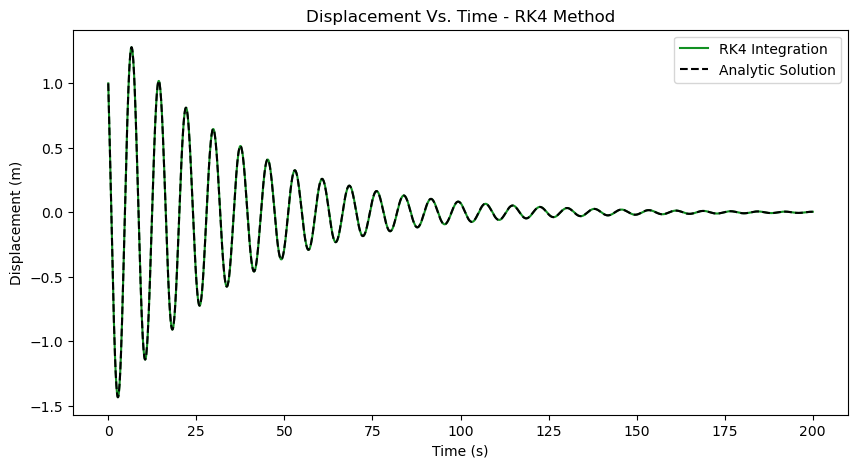

In [110]:
hstep = 0.1
nsteps = int(T/hstep)

#Calculate numerical and analytical solution
x, v, E, time = RK4(hstep, nsteps)
ana_x, ana_v, ana_E = Analytic(time)

plt.figure(figsize = (10,5))

plt.plot(time, x, label='RK4 Integration', c=COLOUR[4])
plt.plot(time, ana_x, 'k--', label='Analytic Solution')
plt.title('Displacement Vs. Time - RK4 Method')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')

plt.legend()
plt.show()


[]

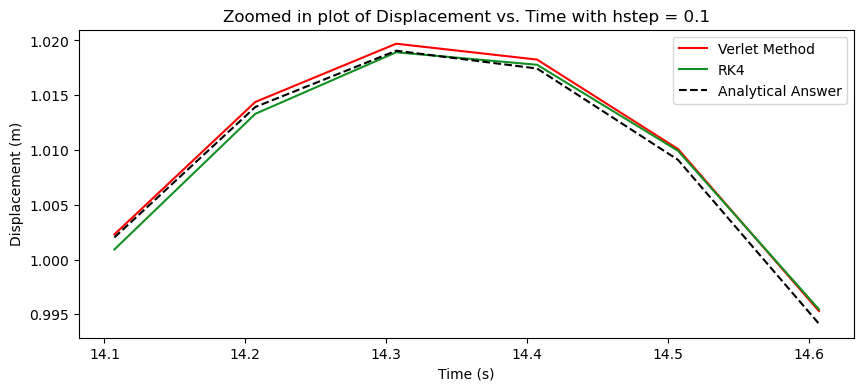

In [111]:
hstep = 0.1
nsteps = int(T/hstep)
x, v, E, time = RK4(hstep, nsteps)
E_x, E_v, E_E = VerletMethod(nsteps, hstep)
A_x, A_v, _ = Analytic(time)
#Perform zoomed in plot on Euler-Cromer and Verlet methods.
period = (2*np.pi)/(np.sqrt(k/mass - (b ** 2 / (4*mass**2))))
zoom_time = 1.83*period #Working out area around the second peak
end_zoom_time = 1.9*period
length = len(time)
start = round(zoom_time/T*length)
end = round(end_zoom_time/T*length)

plt.plot(time[start:end], E_x[start:end], label='Verlet Method', c=COLOUR[2])
plt.plot(time[start:end], x[start:end], label='RK4', c=COLOUR[4])
plt.plot(time[start:end], A_x[start:end], 'k--', label='Analytical Answer')
plt.title('Zoomed in plot of Displacement vs. Time with hstep = '+str(hstep))
plt.ylabel('Displacement (m)')
plt.xlabel('Time (s)')
plt.legend()
plt.plot()

It is clear from the above graphs that RK4 provides a good solution to a damped spring-mass system. To give a more qualitative answer, we shall look into the average percentage uncertainty, as we did earlier.

In [41]:
def average_uncertainty_RK4(hstep):
    '''Function to calculate average percentage uncertainty on RK4 and Verlet method
    Parameters:
    hstep - gap in time in between calculations - float
    -------
    Returns:
    err_RK4 - average percentage uncertainty for RK4 method
    err_Ver - average percentage uncertainty for Verlet method'''
    nsteps = int(T/hstep)
    time = np.linspace(0,T, nsteps)
    RK4_x, _, RK4_E, _ = RK4(hstep, nsteps)
    (ver_x, _, ver_E) = VerletMethod(nsteps, hstep)
    ana_x, _, ana_E = Analytic(time)
    #Calcualte Percentage Uncertainty
    err_RK4 = np.mean(np.abs(RK4_E - ana_E) / RK4_E)
    err_Ver = np.mean(np.abs(ver_E - ana_E) / ver_E)
    return (err_RK4, err_Ver)

At the time step 0.1s, the Verlet Method has an average percentage uncertainty of 0.00320, whereas the RK4 method has an uncertainty of 0.00294


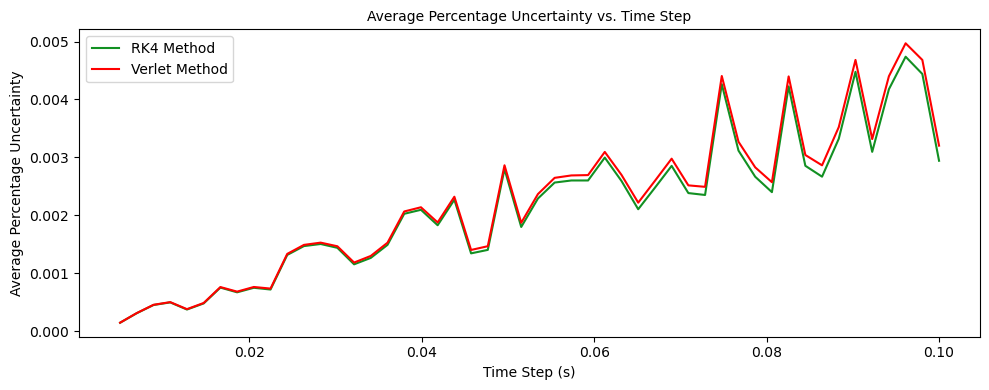

In [112]:
hsteps = np.linspace(0.005,.1,50)

#Create empty lists for each method
err_RK4 = np.zeros(len(hsteps))
err_Ver = np.zeros(len(hsteps))
err_Cromer = np.zeros(len(hsteps))

#For each hstep, calculate the average percentage uncertainty
for index,hstep in enumerate(hsteps):
    (err_RK4[index], err_Ver[index]) = average_uncertainty_RK4(hstep)

plt.rcParams["figure.figsize"] = (10,4)

plt.plot(hsteps, err_RK4, c=COLOUR[4], label='RK4 Method')
plt.plot(hsteps, err_Ver, c=COLOUR[2], label='Verlet Method')
plt.title('Average Percentage Uncertainty vs. Time Step', fontsize=10)
plt.xlabel('Time Step (s)')
plt.ylabel('Average Percentage Uncertainty')

plt.legend()
plt.tight_layout()
plt.plot()


print('At the time step 0.1s, the Verlet Method has an average percentage uncertainty of {:.5f}, whereas the RK4 method has an uncertainty of {:.5f}'
      .format(err_Ver[-1], err_RK4[-1])) 


We have once again analyzed the average percentage uncertainty with increased time step, as seen in this graph the RK4 method seems to have a slightly smaller average percentage uncertainty than the Verlet Method. The RK4 method is also self-starting which is another benefit. However, it achieves its smaller percentage uncertainty by essentially doing 4 time steps in one, making it take more computational power, which could be a disadvantage when a quicker method is needed. Additionally, the RK4, like its predecessor the Euler Method, is non-symplectic.

### Investigating computational time needed
Different methods will take more computational time and power to perform their simulation, this can be seen by studying how long it takes for one simulation to complete.

To do this we will perform 10 simulations and average the time taken for each method to perform them.


In [93]:
hstep = 0.1
nsteps = int(T/hstep)

RK4_time_start = datetime.now() #Setting a time marker
for i in range(10):
    RK4_x, RK4_v, RK4_E, _ = RK4(hstep, nsteps) #Simulation run 10 times
    
RK4_time = datetime.now() - RK4_time_start #Calculating how long between the start and end

Ver_time_start = datetime.now() #Setting a time marker
for i in range(10):
    Ver_x, Ver_v, Ver_E = VerletMethod(nsteps, hstep) #Simulation run 10 times
    
Ver_time = datetime.now() - Ver_time_start


print("The RK4 method takes {:.0f} microseconds, whereas the Verlet method takes {:.0f} microseconds.".format(RK4_time.microseconds/10, Ver_time.microseconds/10))
factor = RK4_time.microseconds / Ver_time.microseconds
print("The RK4 method is slower by a factor of {:.2f}".format(factor))

The RK4 method takes 37520 microseconds, whereas the Verlet method takes 12019 microseconds.
The RK4 method is faster by a factor of 3.12


As seen from the above statement, the RK4 is slower by a significant factor. This could become a much bigger issue for the RK4 method for larger and more complex simulations.

# Conclusion

Throughout this project, we have studied the differences in accuracy between five different numerical methods. This was first done qualitatively and graphically by studying plots of the analytical solution against each numerical method, this already showed a large uncertainty in the Euler and Improved Euler methods, whereas the Verlet and Euler-Cromer were indistinguishable from each other and the analytical solution. We then used the average percentage uncertainty to study how these errors behaved with a change in the time step. This once again showed that the Euler and Improved Euler methods had much larger uncertainties compared to Verlet and Euler-Cromer. We then showed why the Euler and Improved Euler methods had these large uncertainties, due to them being non-symplectic. In conclusion, the Verlet method is the best of the first four methods that we analysed, despite not being self-starting, and having the lowest uncertainty in all aspects of the system.

We then moved on to study the uncertainties on the 4th order Runge-Kutta which, despite being non-symplectic, performed very well and was slightly more accurate over the defined time step range. It has other advantages over the Verlet method, such as being self-starting, however, it required more computational power, which could become a bigger issue in larger and more complex systems.